In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow import keras
from math import sqrt

from tensorflow.keras.utils import plot_model

In [45]:
class Stock:
    def __init__(self, stockName, filePath):

        self.data = pd.read_csv(filePath, header = 0, parse_dates=[0], index_col = 0, squeeze= True)
        self.data = self.data.dropna(0)
        
        self.name = stockName
       
        self.train_samplesX = np.array
        self.test_samplesX = np.array
        self.train_samplesY = np.array
        self.test_samplesY = np.array
        self.scaler = MinMaxScaler
        self.normalizedData = np.array
        self.normDataHistory = np.array
        self.nextDayVals = np.array
        self.nextDaysVals_test = np.array
        self.nextDayValsNorm = np.array
        self.model = keras.Model()
        
   
        
        self.testProp = .2
        self.numLag = 1
        self.numSeq = 1
        self.numEpochs = 1
        self.numNeurons = 1
        self.batchSize = 32

    def show_head(self):
        print(self.data.head())

    def plot(self):
        register_matplotlib_converters()
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,20),dpi=300)
        
        
        ax1.set_title(self.name + " Longitudinal Open Prices")
        ax1.plot(self.data['Open'][::30])
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Stock Price USD [$]')
        
        ax2.set_title(self.name + " Longitudinal Volume")
        ax2.plot(self.data['Volume'][::30])
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Stock Volume')
        fig.savefig(self.name+"_plot.png")
        plt.show()
        

    
        

    def difference(self,dataset, interval=1):
            diff = list()
            for i in range(interval, len(dataset)):
                value = dataset[i] - dataset[i - interval]
                diff.append(value)

            return pd.Series(diff)


    def prepare_samples(self):
        self.scaler = MinMaxScaler(feature_range=(0,1))
        self.normalizedData = self.scaler.fit_transform(self.data)
        
        self.normDataHistory = np.array([self.normalizedData[i : i + self.numSeq].copy() for i in range(len(self.normalizedData)-self.numSeq)])
        self.nextDayValsNorm = np.array([self.normalizedData[:,0][i+self.numSeq].copy() for i in range(len(self.normalizedData)-self.numSeq)])
        self.nextDayValsNorm = np.expand_dims(self.nextDayValsNorm,-1)
        
        self.nextDayVals = np.array([self.data.values[:,0][i+ self.numSeq].copy() for i in range(len(self.data) - self.numSeq)])
        
        self.nextDayVals = np.expand_dims(self.nextDayVals,-1)
        
        yNormalizer = MinMaxScaler()
        yNormalizer.fit(self.nextDayVals)
        
        self.scaler = yNormalizer
        
        assert self.normDataHistory.shape[0] == self.nextDayValsNorm.shape[0]
        
        
    def split_data(self):
        split = self.normDataHistory.shape[0]-int(self.normDataHistory.shape[0] * self.testProp)
        
        self.train_samplesX, self.test_samplesX = self.normDataHistory[:split], self.normDataHistory[split:]
        self.train_samplesY, self.test_samplesY = self.nextDayValsNorm[:split],self.nextDayValsNorm[split:]
        self.nextDayVals_test = self.nextDayVals[split:]
    
    def set_globals(self,testProp,batchSize,numSeq,numNeurons,numEpochs):
        self.testProp = testProp
        self.batchSize = batchSize
        self.numSeq = numSeq
        self.numNeurons = numNeurons
        self.numEpochs = numEpochs
        
        
    def fit_LSTM(self):
        lstm_input = keras.layers.Input(shape=(self.numSeq,self.data.shape[1]),name='lstm_input')
        x = keras.layers.LSTM(self.numNeurons,name='LSTM_0')(lstm_input)
        x = keras.layers.Dropout(0.2,name='lstm_dropout_0')(x)
        x = keras.layers.Dense(64,name='dense_0')(x)
        x = keras.layers.Activation('sigmoid',name='sigmoid_0')(x)
        x = keras.layers.Dense(1,name='dense_1')(x)
        output = keras.layers.Activation('linear',name='linear_output')(x)
        self.model = keras.Model(inputs=lstm_input,outputs=output)
        
        self.model.compile(optimizer='adam',loss='mse')
       # plot_model(model,to_file='model.png')
        
        self.model.fit(x=self.train_samplesX,y=self.train_samplesY,batch_size=self.batchSize,epochs=self.numEpochs,shuffle=True,validation_split=.1)
        evaluation = self.model.evaluate(self.test_samplesX,self.test_samplesY)
        print(evaluation)
            
    
    def evaluate_forecasts(self):

        predictedPrices = self.model.predict(self.test_samplesX)
        predictedPrices = self.scaler.inverse_transform(predictedPrices)
        
        MSE = np.mean(np.square(self.nextDayVals_test - predictedPrices))
        MSE_scaled = MSE / (np.max(self.nextDayVals_test) - np.min(self.nextDayVals_test)) * 100
        print(MSE_scaled)
        
        fig = plt.figure(figsize=(20,10),dpi=300)
        actual = plt.plot(self.nextDayVals_test,label='actual')
        predicted = plt.plot(predictedPrices,label='predicted')
        plt.legend(['Actual','Predicted'])
        plt.show()
        fig.savefig(self.name+"forecastplot.png")
            
   

                Open      High       Low     Close  Adj Close       Volume
Date                                                                      
1980-12-12  0.513393  0.515625  0.513393  0.513393   0.406782  117258400.0
1980-12-15  0.488839  0.488839  0.486607  0.486607   0.385558   43971200.0
1980-12-16  0.453125  0.453125  0.450893  0.450893   0.357260   26432000.0
1980-12-17  0.462054  0.464286  0.462054  0.462054   0.366103   21610400.0
1980-12-18  0.475446  0.477679  0.475446  0.475446   0.376715   18362400.0
Train on 7578 samples, validate on 842 samples
Epoch 1/50
7578/7578 [==============================] - 3s 379us/sample - loss: 2.7401e-04 - val_loss: 5.0539e-05

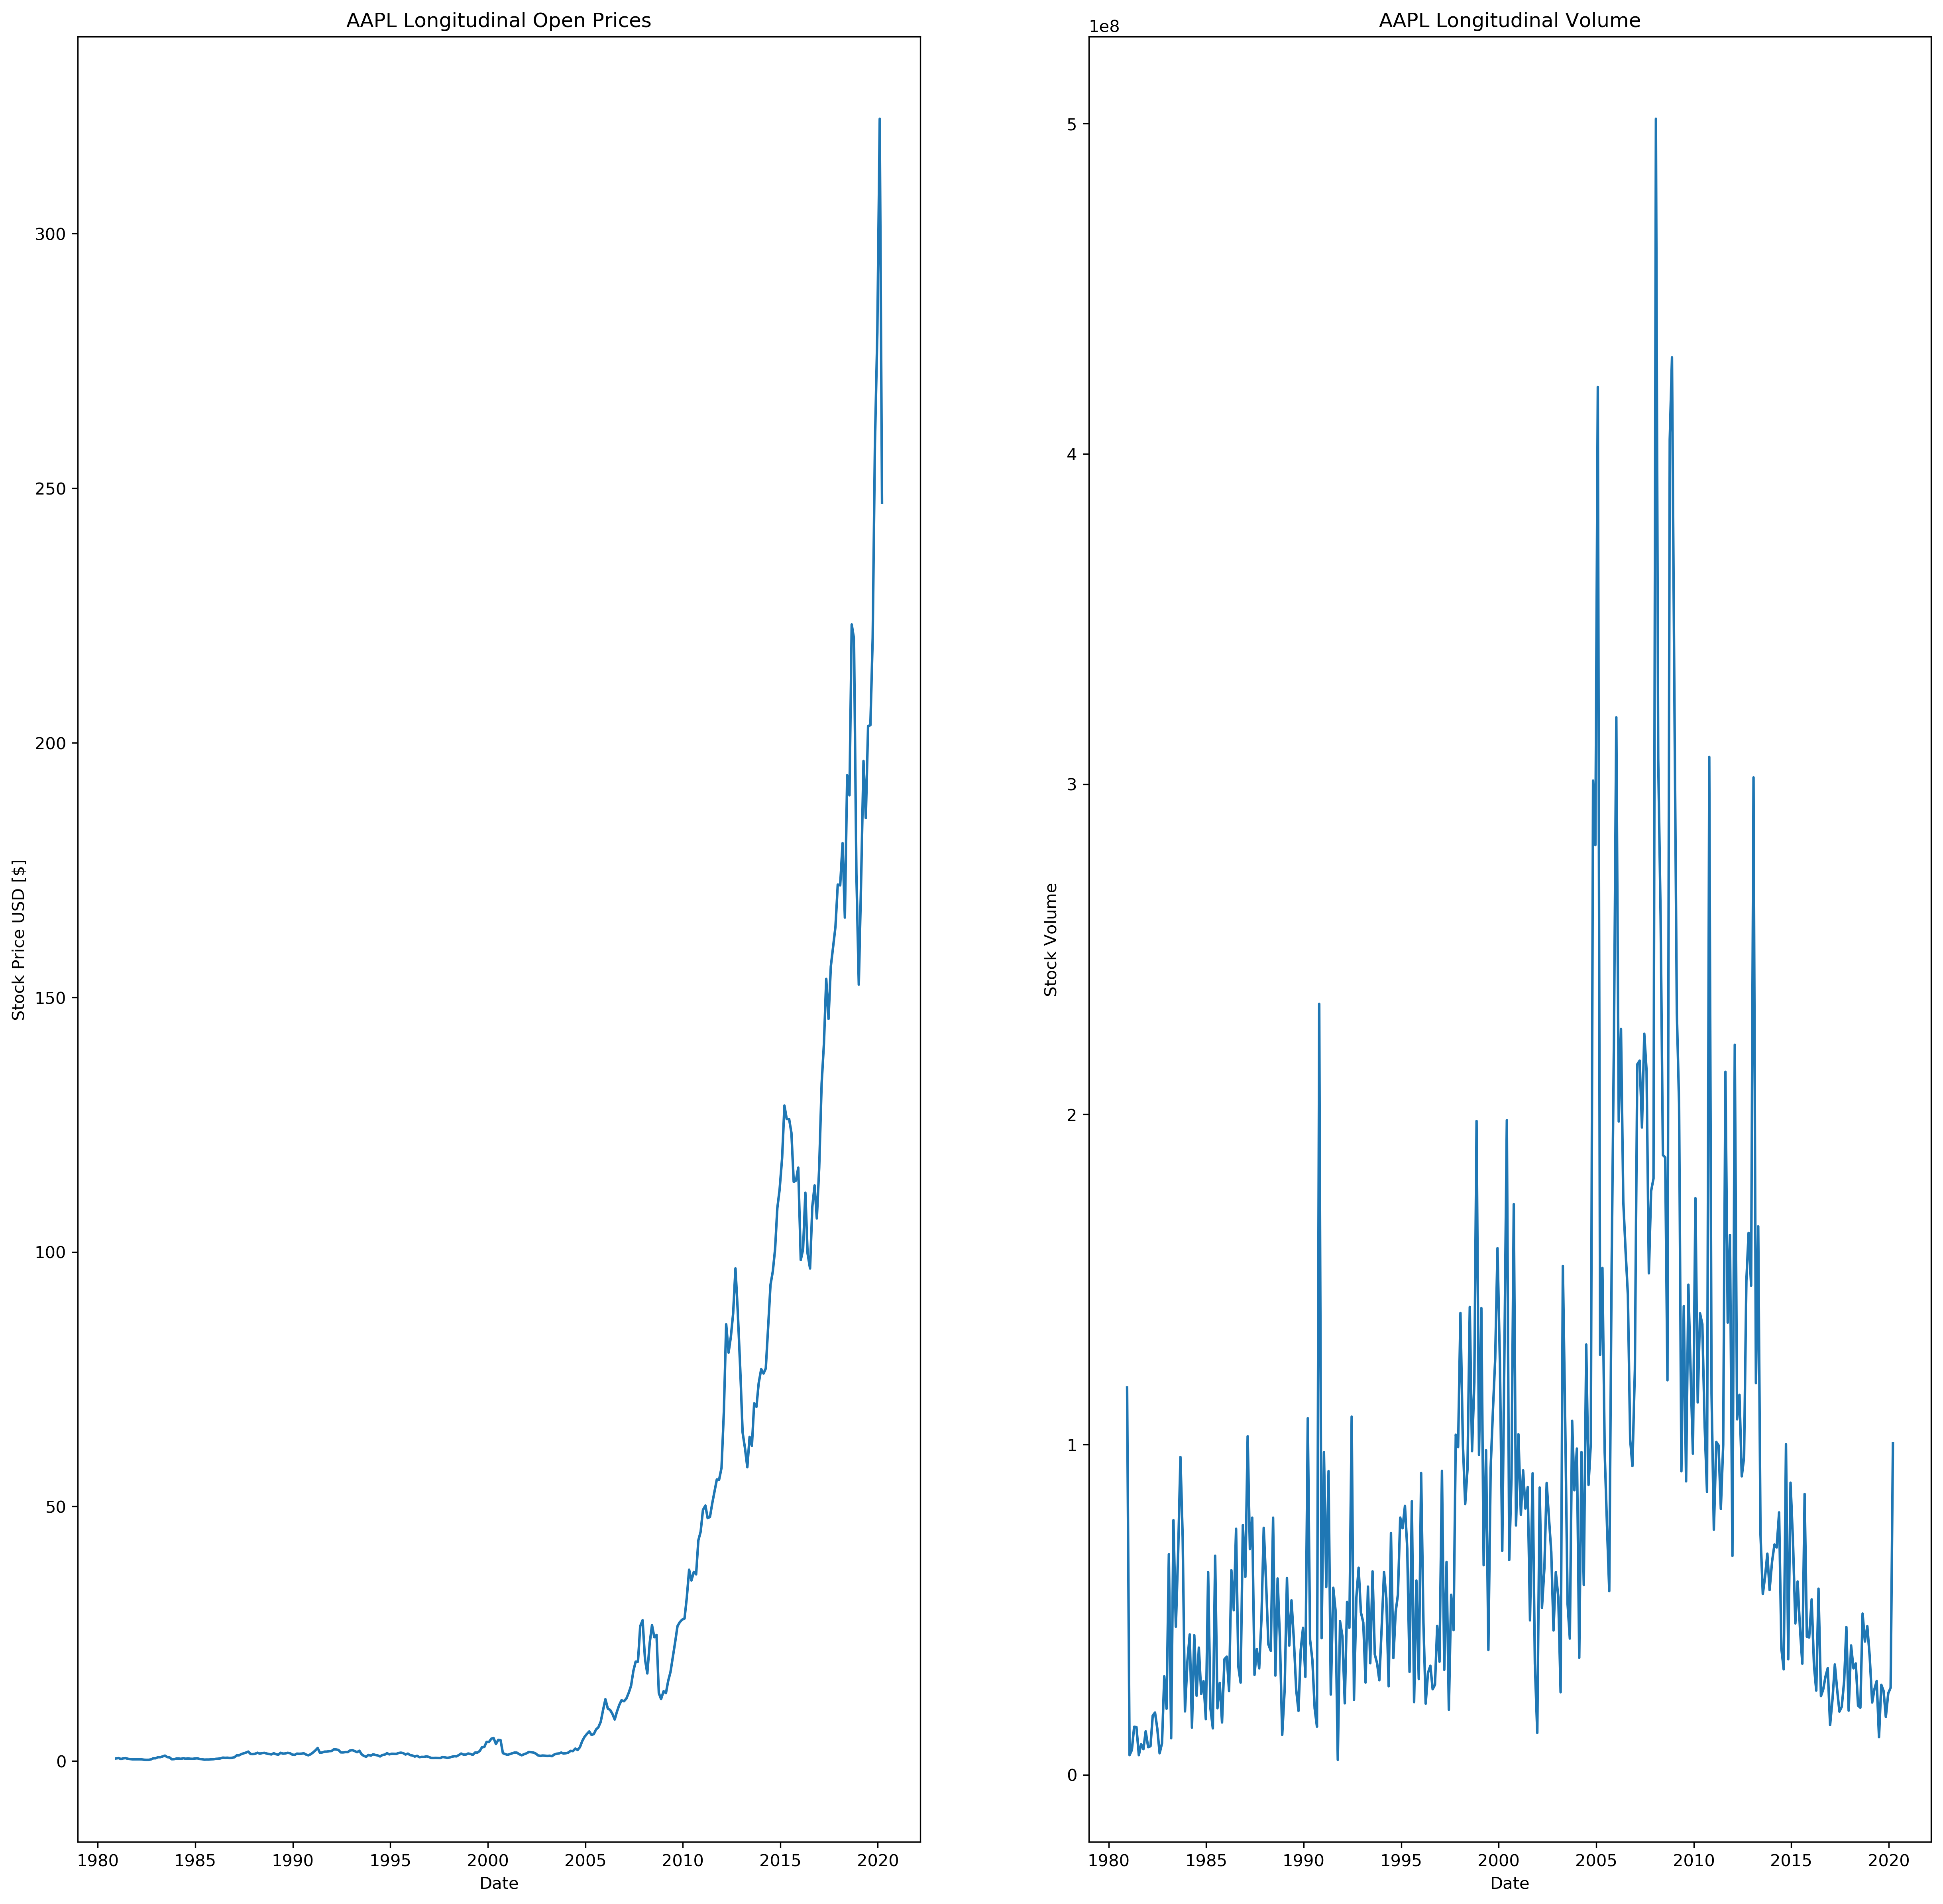

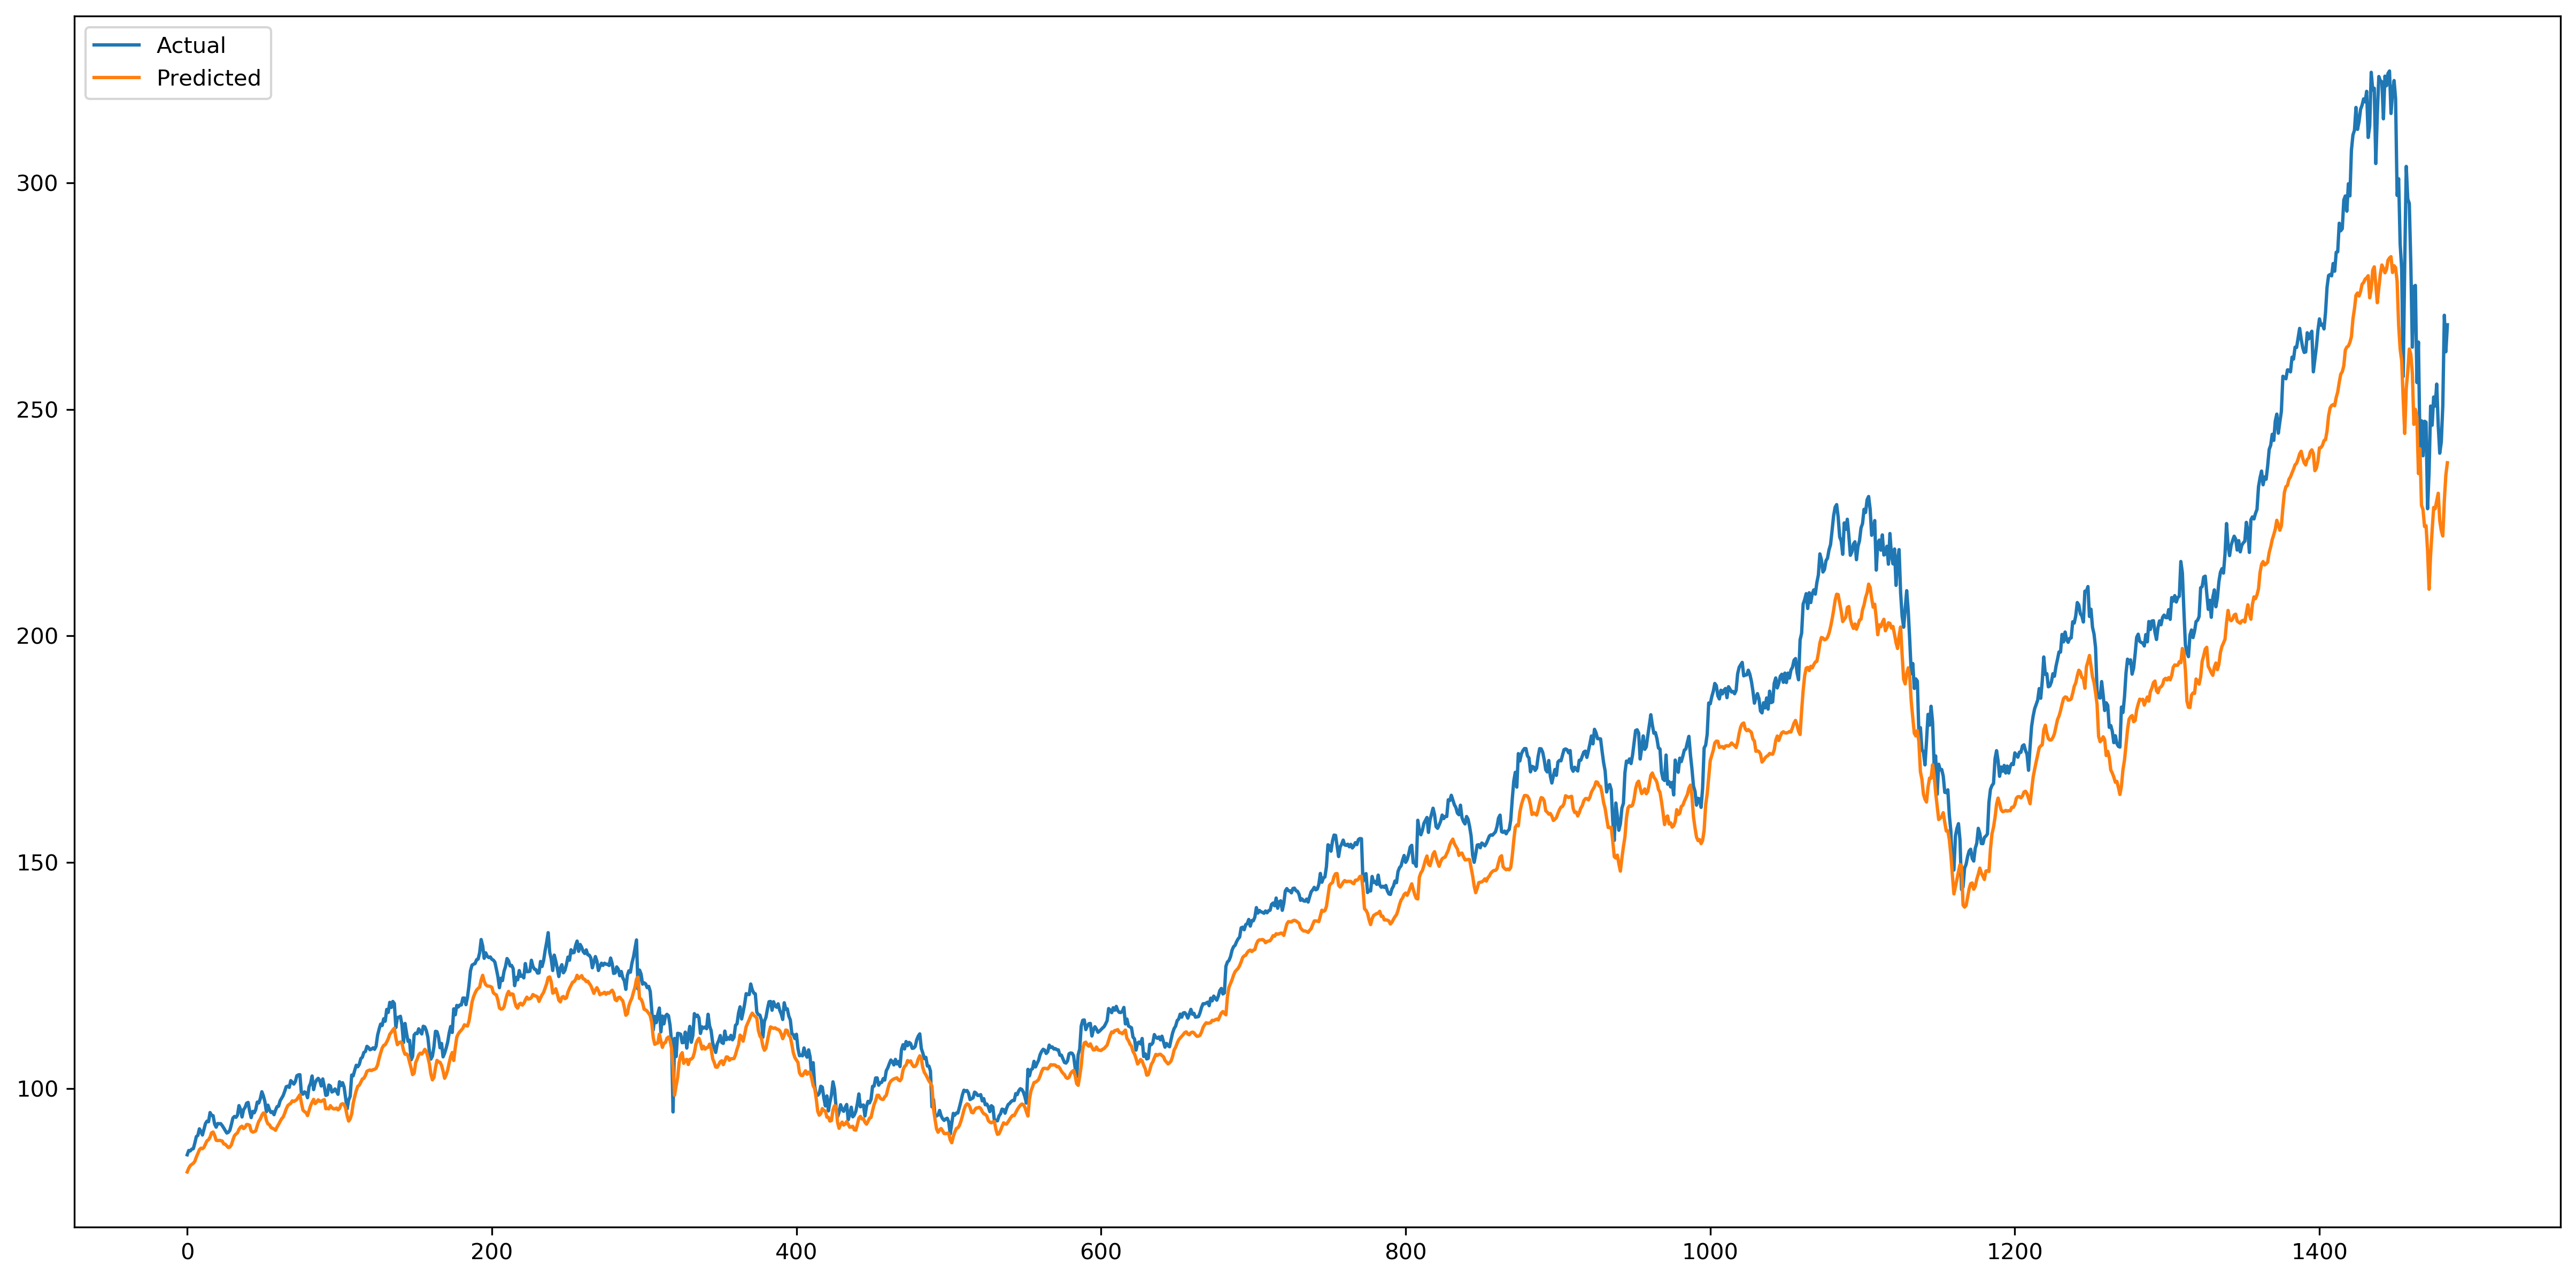

In [46]:

AAPL = Stock("AAPL","AAPL.csv")
AAPL.set_globals(.15,32,5,50,50)
AAPL.show_head()
AAPL.plot()
AAPL.prepare_samples()
AAPL.split_data()
AAPL.fit_LSTM()
AAPL.evaluate_forecasts()



                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2006-05-22  36.520000  37.290001  35.869999  37.230000  34.038883  197100
2006-05-23  37.750000  39.220001  37.750000  37.959999  34.706322  620900
2006-05-24  37.130001  37.570000  35.869999  36.520000  33.389740  638600
2006-05-25  37.180000  38.320000  36.980000  38.320000  35.035458  367000
2006-05-26  38.740002  38.740002  37.770000  38.549999  35.245750  269400
Train on 2621 samples, validate on 292 samples
Epoch 1/50
2621/2621 [==============================] - 2s 877us/sample - loss: 0.0161 - val_loss: 3.7276e-04

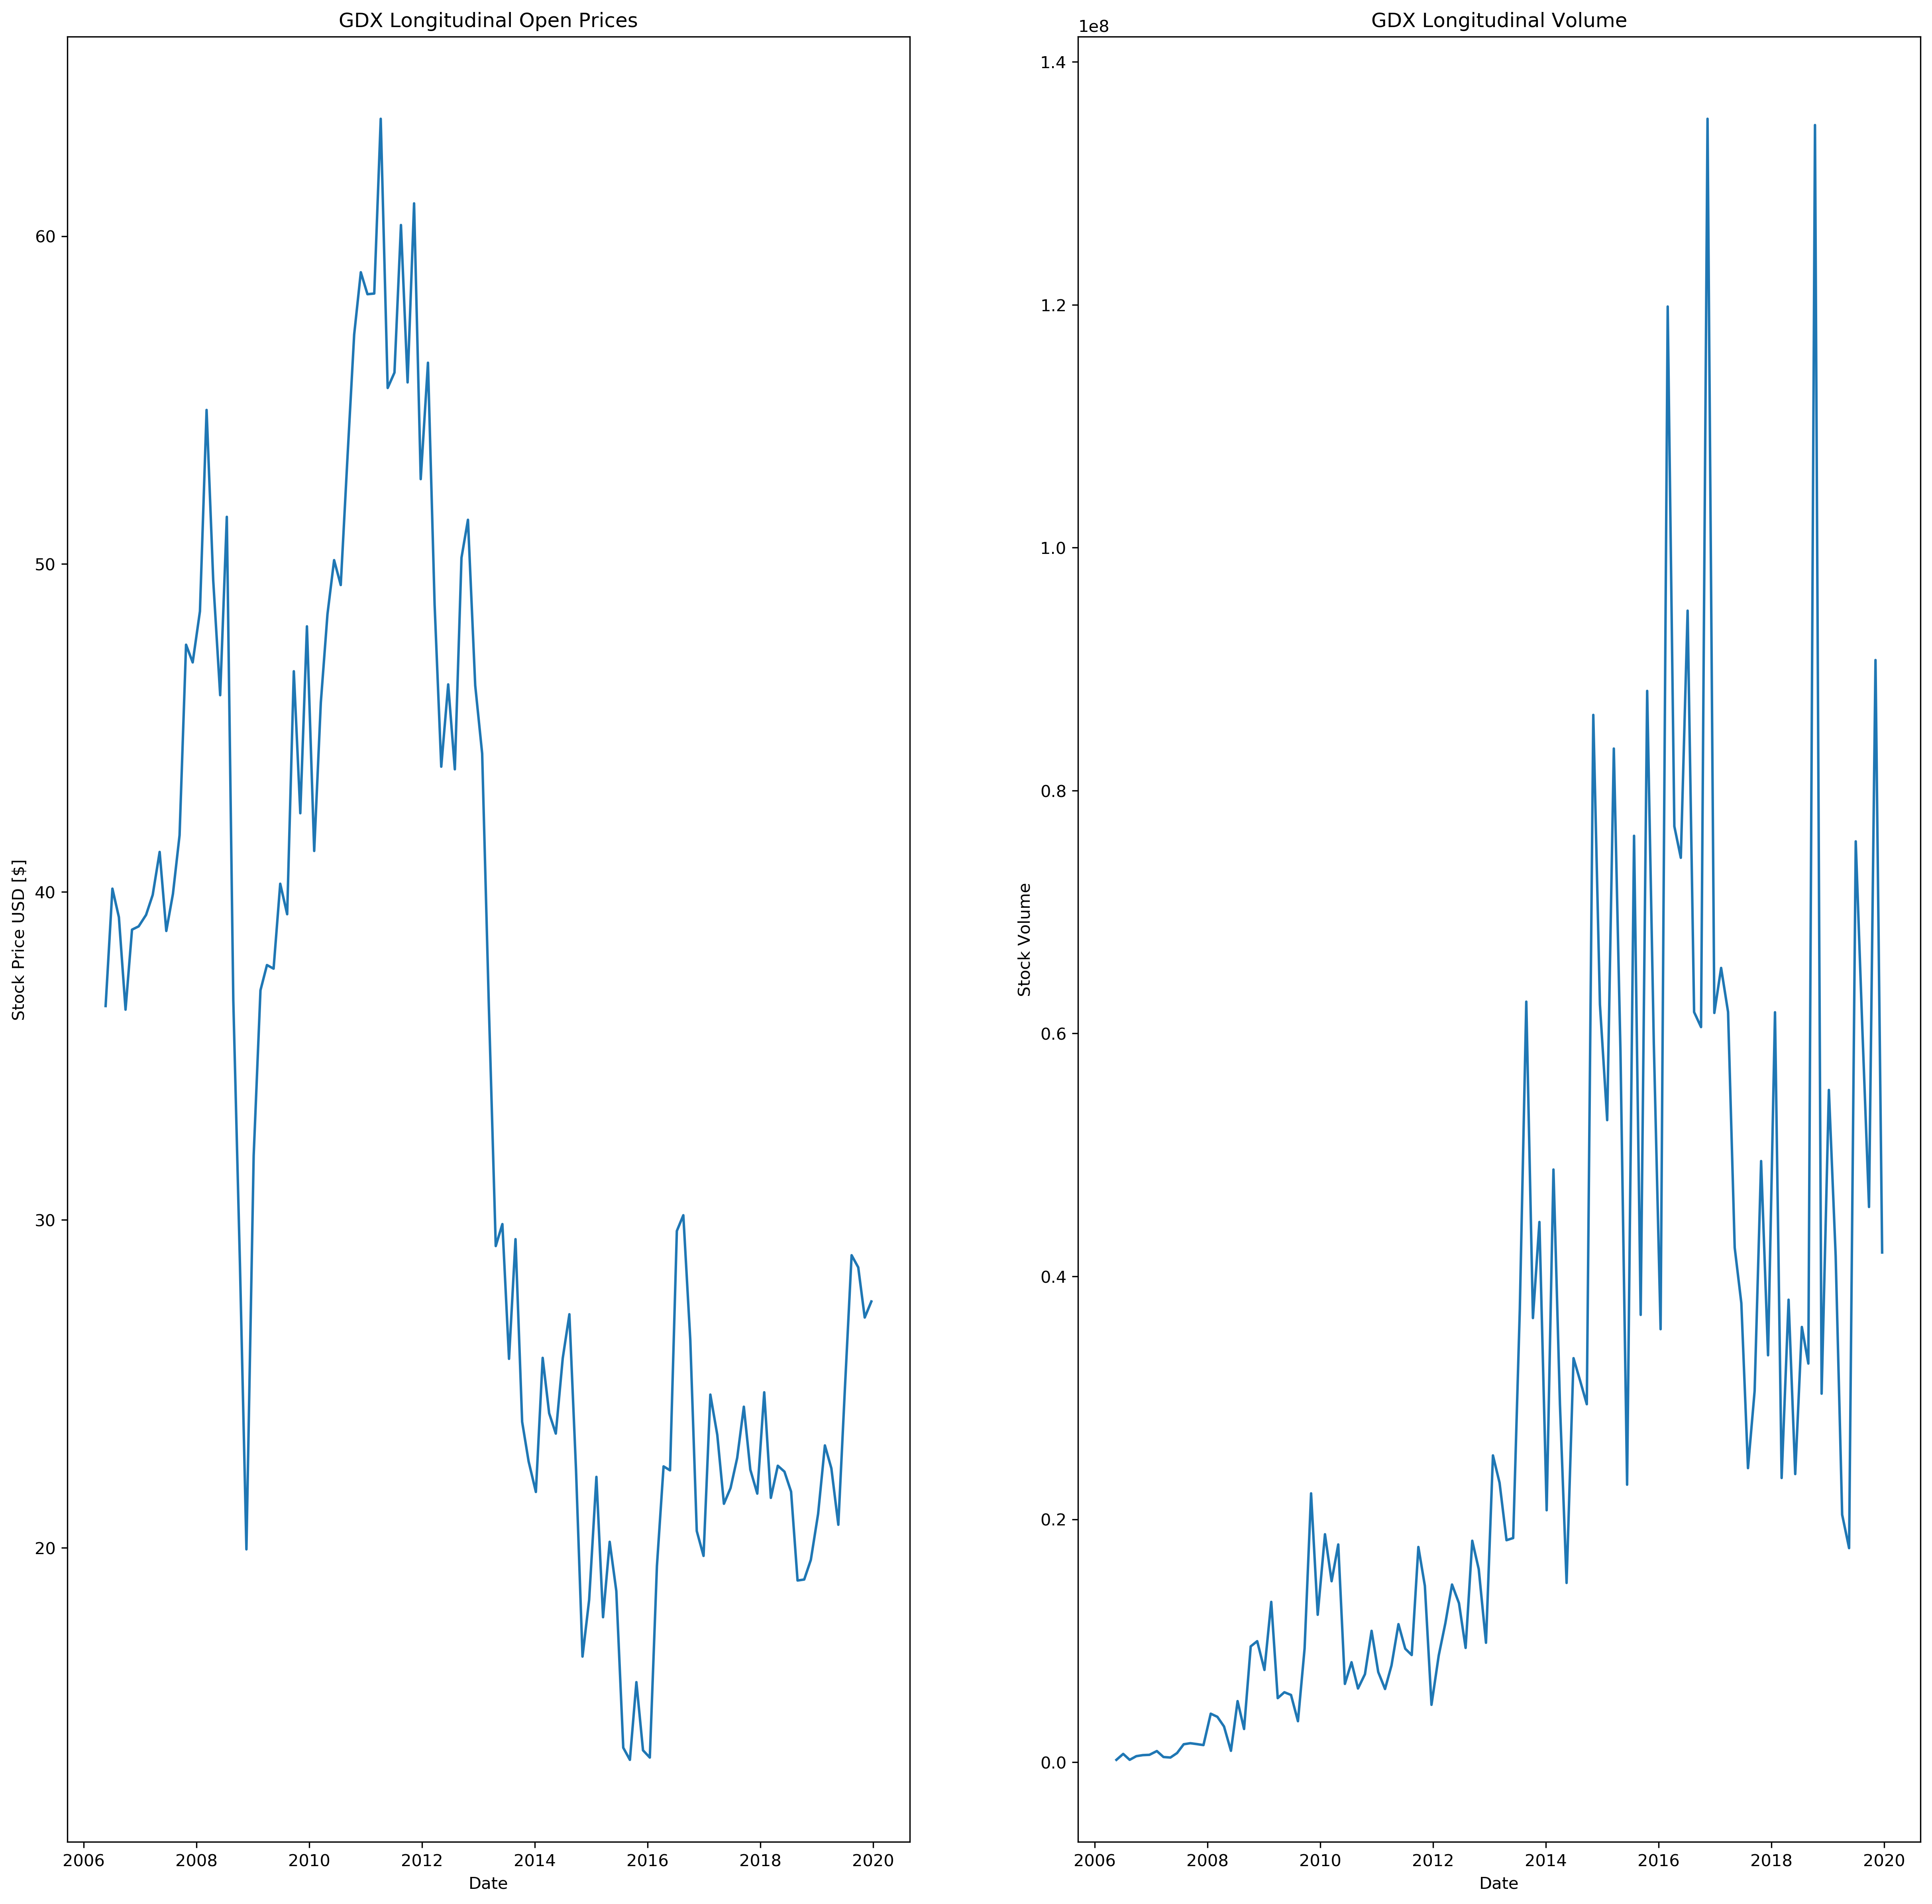

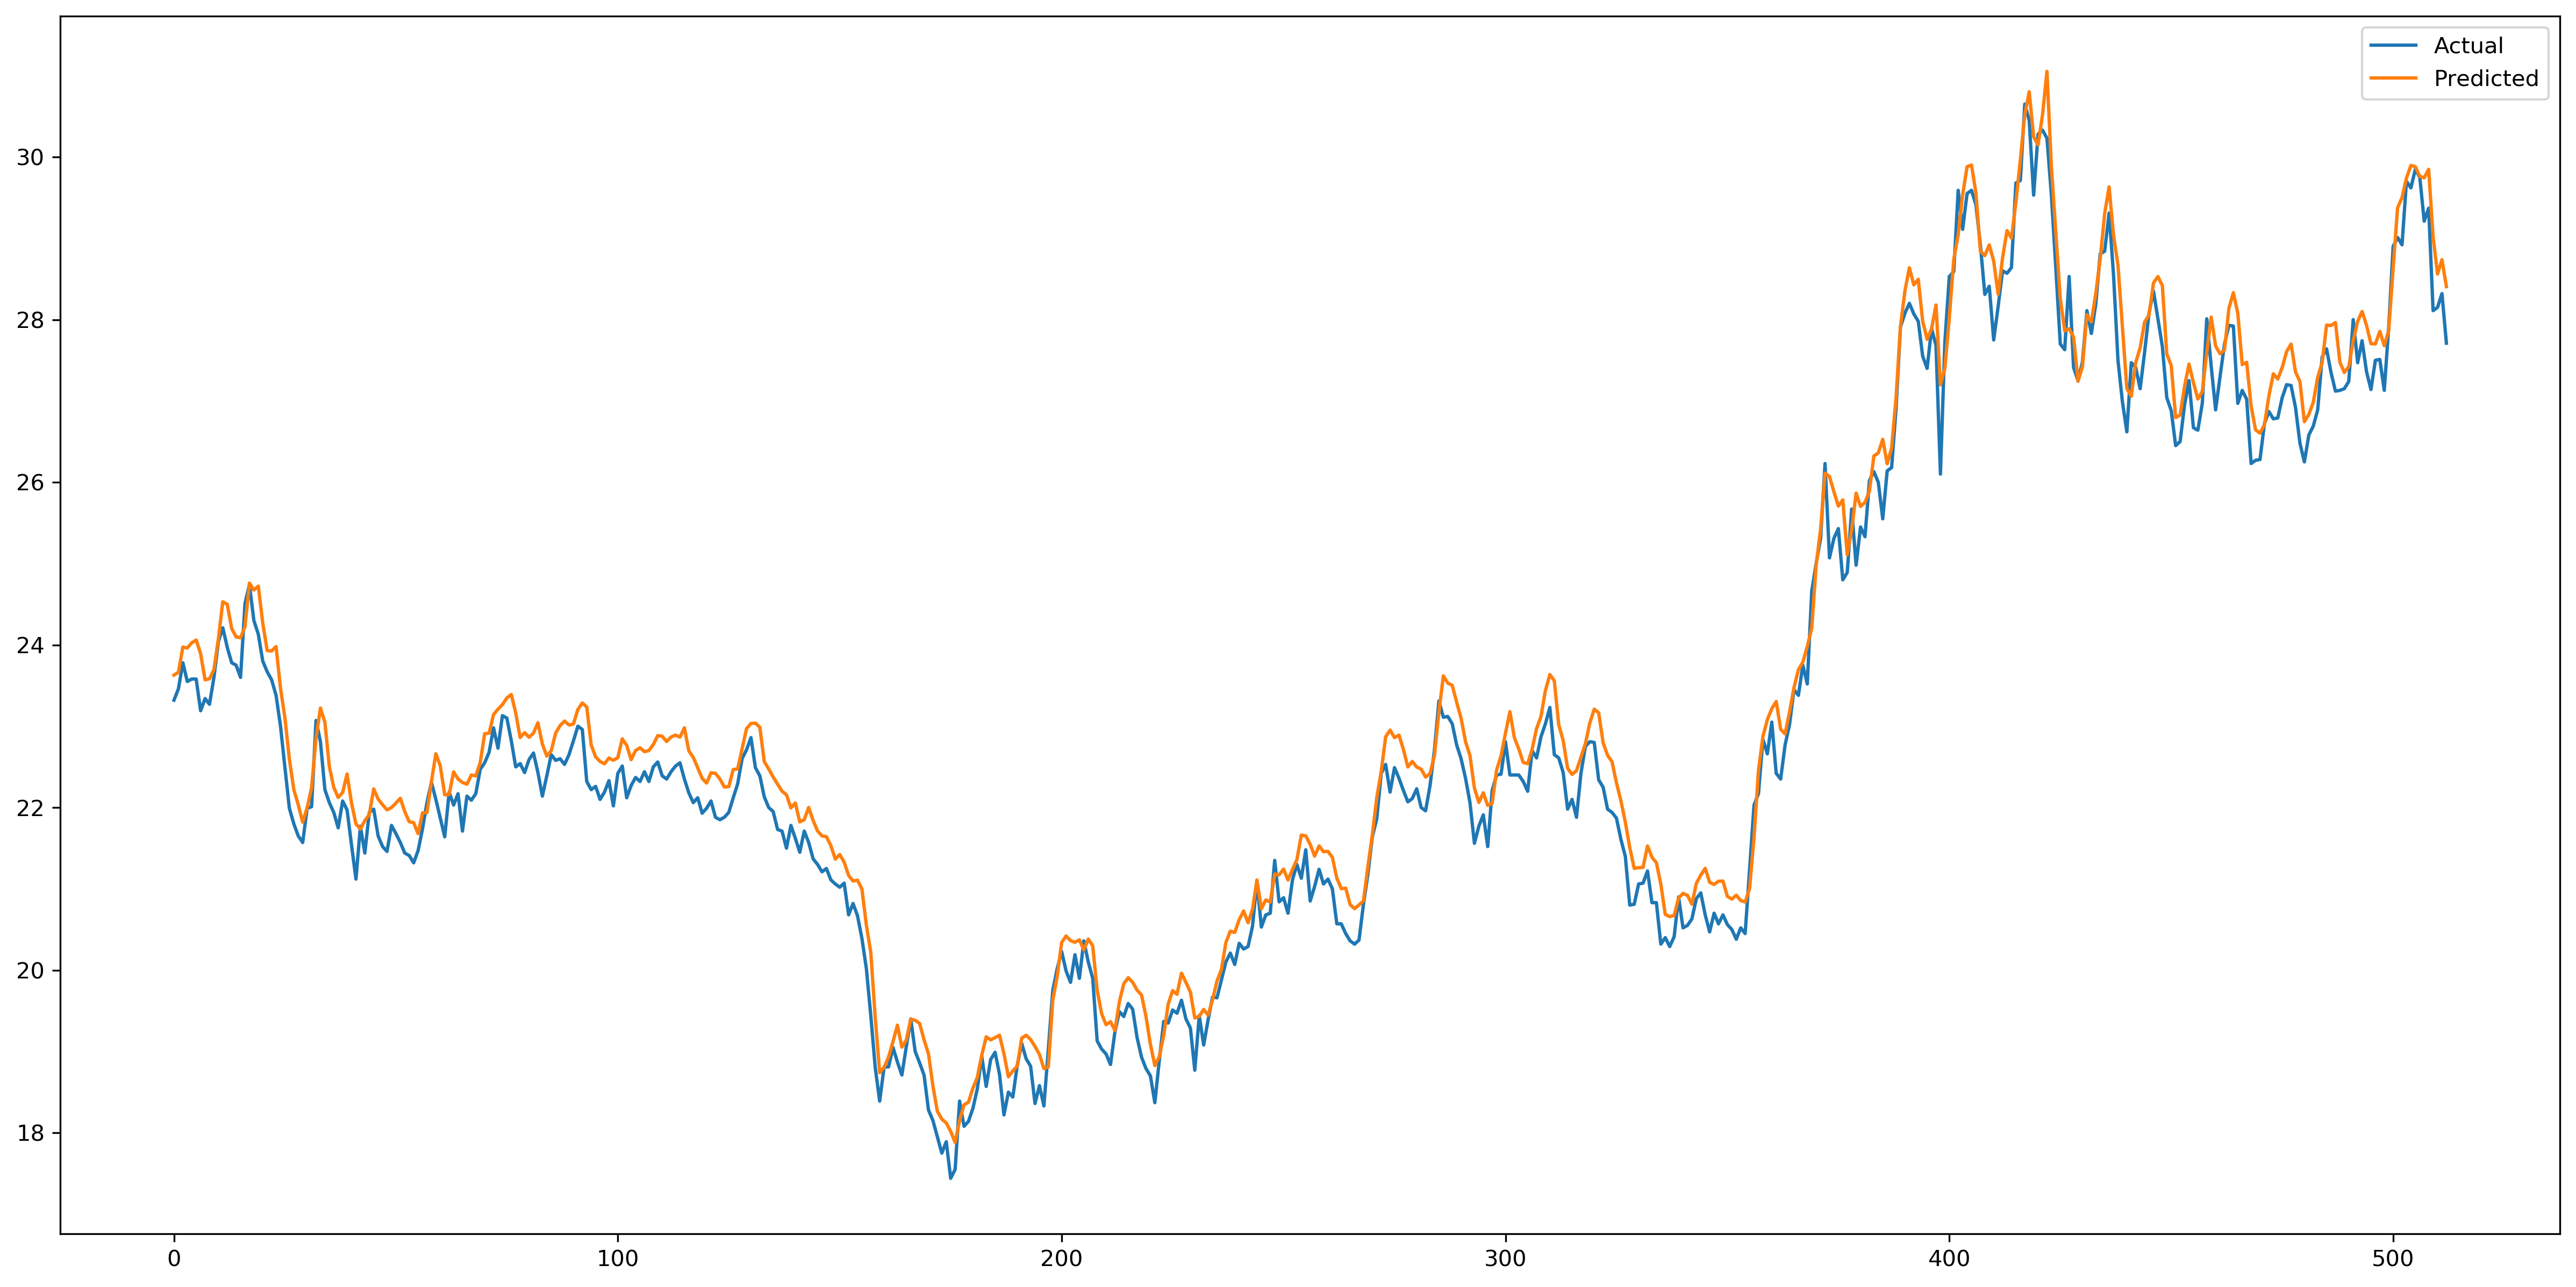

In [43]:
GDX = Stock("GDX","GDX.csv")
GDX.set_globals(.15,32,10,50,50)
GDX.show_head()
GDX.plot()
GDX.prepare_samples()
GDX.split_data()
GDX.fit_LSTM()
GDX.evaluate_forecasts()



                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2005-01-03  98.050003  98.050003  97.019997  97.089996  73.421463   20400
2005-01-04  97.400002  97.489998  96.000000  96.169998  72.725739  184100
2005-01-05  96.239998  96.430000  95.610001  95.610001  72.302261   27700
2005-01-06  96.000000  96.360001  95.750000  96.260002  72.793816   16500
2005-01-07  96.449997  96.449997  95.639999  95.639999  72.324951   19600


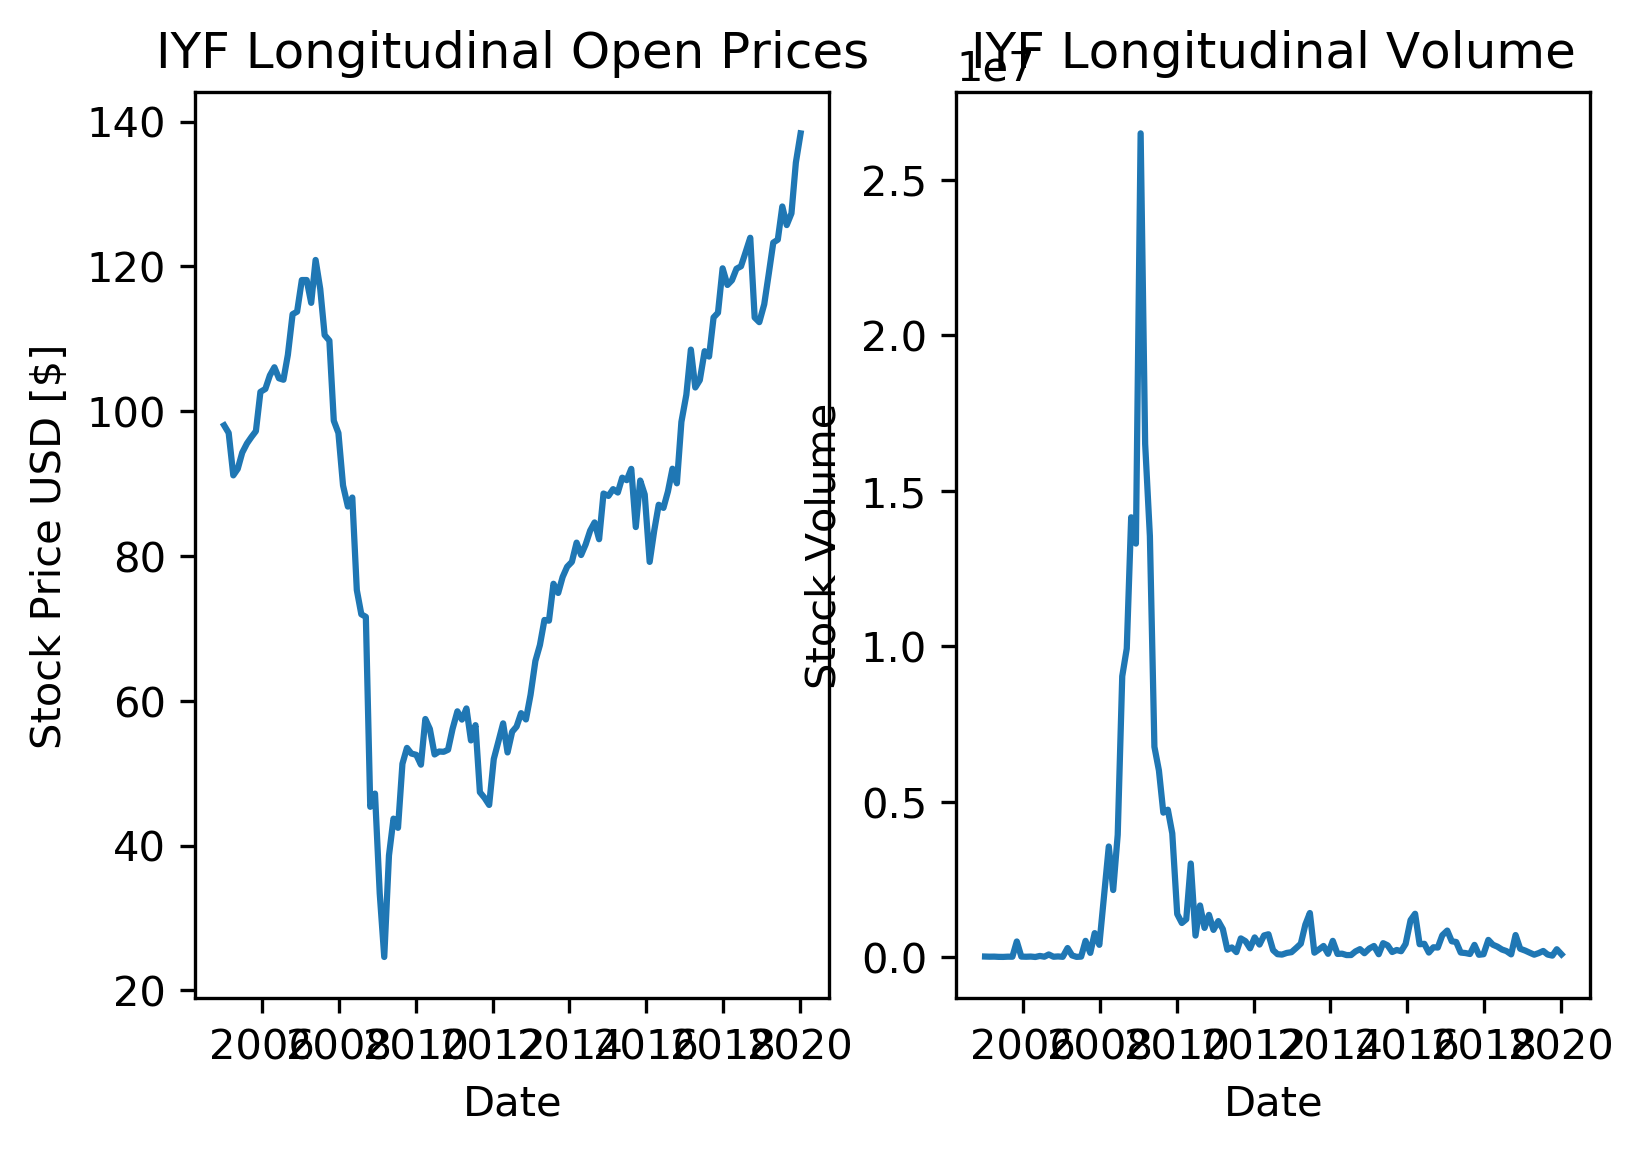

ValueError: Failed to find data adapter that can handle input: <class 'builtin_function_or_method'>, <class 'builtin_function_or_method'>